In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
import pandas as pd

RUN_VARS = ["01", "05", "06", "07", "08"]
VARS = ["tasmax", "tasmin", "pr"]


def get_root_filepath():
    return "https://climrecal.blob.core.windows.net/analysis/cpm-median-time-series"

In [2]:
def add_cols(df):
    df["day"] = df["time"].apply(lambda x: x.timetuple().tm_yday)
    df["month"] = df["time"].apply(lambda x: x.month)
    df["year"] = df["time"].apply(lambda x: x.year)
    df["day_of_month"] = df["time"].apply(lambda x: x.day)
    df["leap_year"] = df["time"].apply(lambda x: x.year % 4 == 0)
    return df


def get_days(is_leap_year: bool) -> np.array:
    if not is_leap_year:
        # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.convert_calendar.html
        #  February 6th (36), April 19th (109), July 2nd (183), September 12th (255), November 25th (329).
        # First missing day should be 37, not 36 since February 6th is 37
        return np.array([37, 109, 183, 255, 329])
    else:
        # January 31st (31), March 31st (91), June 1st (153), July 31st (213), September 31st (275) and November 30th (335).
        return np.array([31, 91, 153, 213, 275, 335])


def get_data() -> dict[str, dict[str, tuple[pd.DataFrame, pd.DataFrame]]]:
    data = {}
    for var in VARS:
        data[var] = {}
        for run_var in RUN_VARS:
            path_raw = f"{get_root_filepath()}/cpm-raw-medians/median-{var}-{run_var}.nc#mode=bytes"
            path_con = f"{get_root_filepath()}/cpm-converted-linear-medians/median-{var}-{run_var}.nc#mode=bytes"
            path_con_near = f"{get_root_filepath()}/cpm-converted-nearest-medians/median-{var}-{run_var}.nc#mode=bytes"
            x_raw = xarray.load_dataset(path_raw)
            x_con = xarray.load_dataset(path_con)
            x_con_near = xarray.load_dataset(path_con_near)
            df_raw = add_cols(
                x_raw.convert_calendar("standard", align_on="year")
                .to_pandas()
                .reset_index()
            )
            df_con = add_cols(x_con.to_pandas().reset_index())
            df_con_near = add_cols(x_con_near.to_pandas().reset_index())
            data[var][run_var] = (df_raw, df_con, df_con_near)
    return data

In [3]:
# Load all data
data = get_data()

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


In [4]:
# Example
var, run_var = "tasmax", "01"
df_raw, df_con, df_con_near = data[var][run_var]

In [5]:
# Missing Day 37
df_raw.iloc[64:70]

,time,tasmax,day,month,year,day_of_month,leap_year
64,1981-02-04 12:00:00,7.901025,35,2,1981,4,False
65,1981-02-05 12:00:00,9.846338,36,2,1981,5,False
66,1981-02-07 12:00:00,10.244776,38,2,1981,7,False
67,1981-02-08 12:00:00,7.123193,39,2,1981,8,False
68,1981-02-09 12:00:00,7.830713,40,2,1981,9,False
69,1981-02-10 12:00:00,7.916040,41,2,1981,10,False


In [6]:
def plot_by_day(
    data,
    var: str,
    run_var: str,
    year: int,
    leap_year: bool,
    plot_diff: bool,
    ax: Axes,
    lw=0.8,
):
    df_raw, df_con, df_con_near = data[var][run_var]
    if not plot_diff:
        for i, df in enumerate([df_raw, df_con, df_con_near]):
            if leap_year is not None:
                df2 = df[df["leap_year"].eq(leap_year)]
            else:
                df2 = df
            if year is None:
                x = df2.groupby("day")[var].median()
            else:
                x = df2[df2["year"].eq(year)].groupby("day")[var].first()
            if i == 0:
                if leap_year is not None:
                    ax.vlines(
                        get_days(leap_year),
                        x.min(),
                        x.max(),
                        zorder=-1,
                        lw=0.4,
                        color="k",
                        ls=":",
                    )
                ax.plot(x.index, x, lw=lw, alpha=0.8)
            else:
                ax.plot(x.index, x, lw=lw, alpha=0.8)
                # pass
    else:
        series = []
        for i, df in enumerate([df_raw, df_con, df_con_near]):
            if leap_year is not None:
                df2 = df[df["leap_year"].eq(leap_year)]
            else:
                df2 = df
            if year is None:
                x = df2.groupby("day")[var].median()
            else:
                x = df2[df2["year"].eq(year)].groupby("day")[var].first()
            series.append(x)

        # Use absolute difference
        x2 = series[1] - series[0]
        x3 = series[2] - series[0]

        ax.vlines(
            get_days(leap_year),
            min([x2.min(), x3.min()]),
            max([x2.max(), x3.max()]),
            zorder=-1,
            lw=0.4,
            color="k",
            ls=":",
        )

        ax.plot(x2.index, x2, lw=lw, alpha=0.8, color="C1", ls="-")
        ax.plot(x3.index, x3, lw=lw, alpha=0.8, color="C2", ls="-")

    ax.set_title(f"Year: {year}, Leap year: {leap_year}")
    if not plot_diff:
        ax.set_ylabel(f"Difference ({var})")
    else:
        ax.set_ylabel(f"Value ({var})")


def plot_by_day_pair(
    data,
    var: str,
    run_var: str,
    year: int,
    leap_year: bool,
    axs: Axes,
    lw=0.8,
    series_diff_tuples: list[tuple] = [(0, 1), (0, 2)],
):
    ax1, ax2 = axs[0], axs[1]
    df_raw, df_con, df_con_near = data[var][run_var]
    series = []
    for i, df in enumerate([df_raw, df_con, df_con_near]):
        if leap_year is not None:
            df2 = df[df["leap_year"].eq(leap_year)]
        else:
            df2 = df
        if year is None:
            x = df2.groupby("day")[var].median()
        else:
            x = df2[df2["year"].eq(year)].groupby("day")[var].first()
        series.append(x)

    # Use difference
    x2 = series[series_diff_tuples[0][1]] - series[series_diff_tuples[0][0]]
    x3 = series[series_diff_tuples[1][1]] - series[series_diff_tuples[1][0]]

    for i, ax in enumerate([ax1, ax2]):
        interp = "linear" if i == 0 else "nearest"
        ax.vlines(
            get_days(leap_year),
            min([x2.min(), x3.min()]),
            max([x2.max(), x3.max()]),
            zorder=-1,
            lw=0.4,
            color="k",
            ls=":",
        )
        ax.set_title(
            f"Year: {year}, Leap year: {leap_year}, Interpolation: {interp}",
            fontsize="medium",
        )
    ax1.plot(x2.index, x2, lw=lw, alpha=0.8, color="C1", ls="-")
    ax2.plot(x3.index, x3, lw=lw, alpha=0.8, color="C2", ls="-")
    ax1.set_ylabel(f"Value ({var})")

In [7]:
def plot_array(data, year, leap_year=True, plot_diff=False, lw=0.8):
    run_vars = RUN_VARS
    vars = VARS
    fig, axs = plt.subplots(
        len(vars),
        len(run_vars),
        squeeze=False,
        sharex=True,
        sharey="row",
        figsize=(14, 6),
    )
    for row, var in enumerate(vars):
        for col, run_var in enumerate(run_vars):
            ax = axs[row][col]
            plot_by_day(data, var, run_var, year, leap_year, plot_diff, ax=ax, lw=lw)
            if col == 0:
                ax.set_ylabel(var, fontsize="medium")
            else:
                ax.set_ylabel("")
            if row == 0:
                ax.set_title(f"Run: {run_var}", fontsize="medium")
            else:
                ax.set_title("")


def plot_array_pair_diff(
    data,
    year,
    leap_year=True,
    run_var="01",
    lw=0.8,
    series_diff_tuples: list[tuple] = [(0, 1), (0, 2)],
):
    run_vars = [run_var]
    vars = VARS
    fig, axs = plt.subplots(
        len(vars),
        2,
        squeeze=False,
        sharex=True,
        sharey="row",
        figsize=(14, 6),
    )
    for row, var in enumerate(vars):
        for col, run_var in enumerate(run_vars):
            ax_pair = axs[row]
            plot_by_day_pair(
                data,
                var,
                run_var,
                year,
                leap_year,
                axs=ax_pair,
                lw=lw,
                series_diff_tuples=series_diff_tuples,
            )
            ax_pair[0].set_ylabel(var, fontsize="medium")

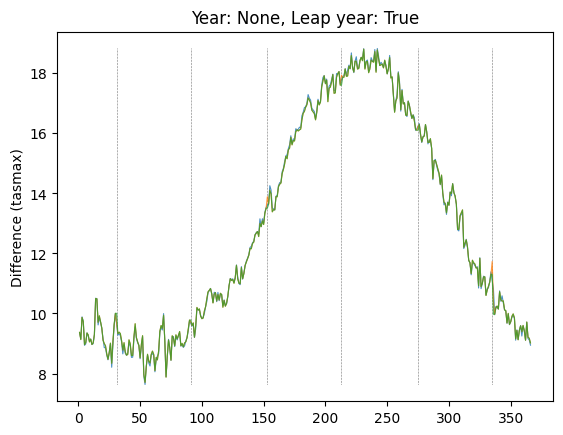

In [8]:
plot_by_day(data, "tasmax", "01", None, leap_year=True, plot_diff=False, ax=plt.gca())

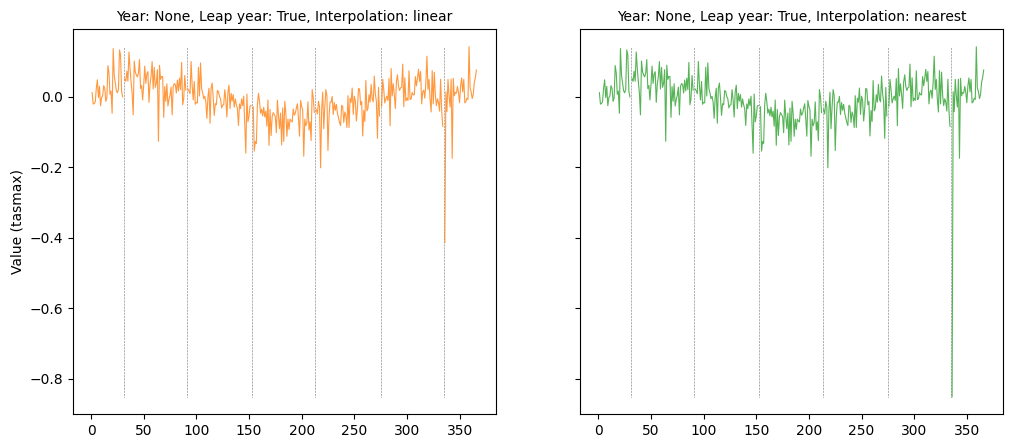

In [9]:
# Differences between series:
#   (orange) linear - raw
#   (green)  nearest - raw
plot_by_day_pair(
    data,
    "tasmax",
    "01",
    None,
    leap_year=True,
    axs=plt.subplots(1, 2, sharey="row", figsize=(12, 5))[1],
    series_diff_tuples=[(0, 1), (0, 2)],
)

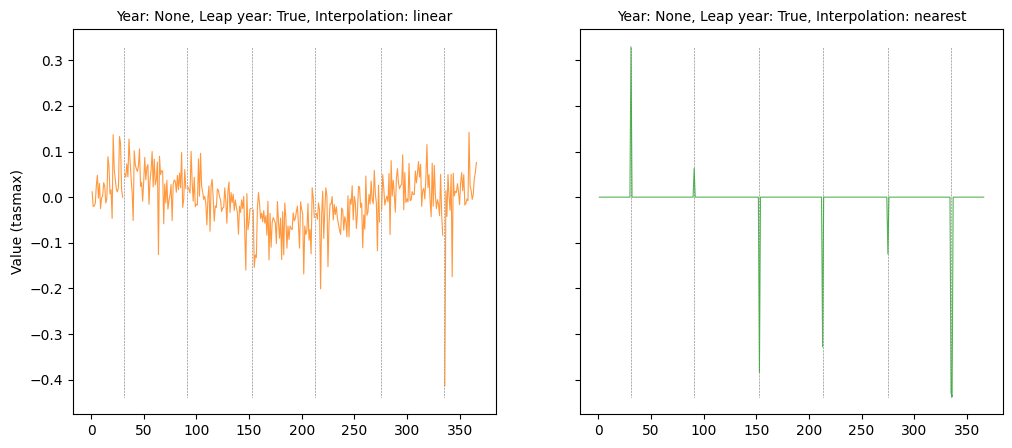

In [10]:
# Differences between series:
#   (orange) linear - raw
#   (green)  nearest - linear
# fig, axs = plt.subplots(1, 2, sharey="row", figsize=(12, 5))
plot_by_day_pair(
    data,
    "tasmax",
    "01",
    None,
    leap_year=True,
    axs=plt.subplots(1, 2, sharey="row", figsize=(12, 5))[1],
    series_diff_tuples=[(0, 1), (1, 2)],
)
# plt.show()

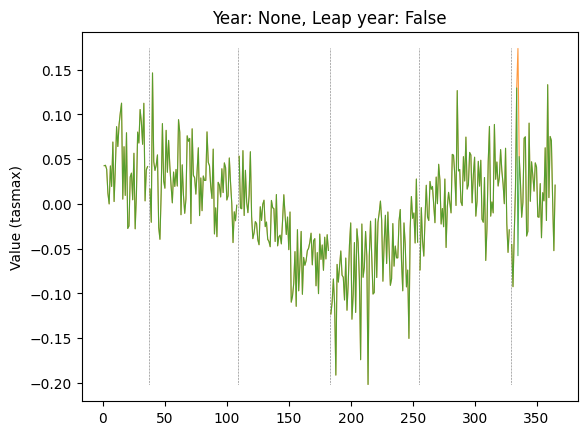

In [11]:
plot_by_day(data, "tasmax", "01", None, leap_year=False, plot_diff=True, ax=plt.gca())

Plot diff: False; year: None; leap_year: True


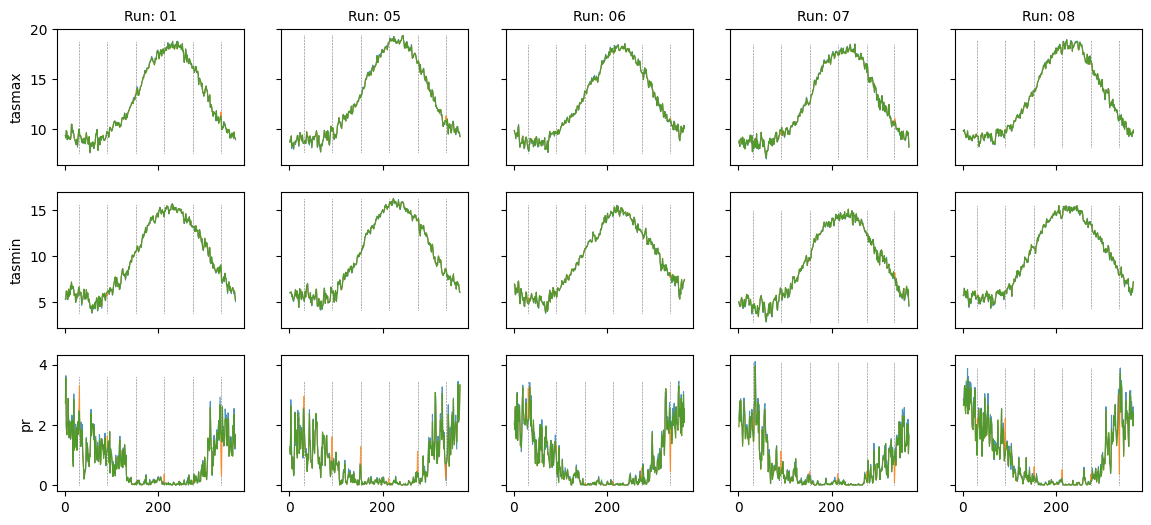

Plot diff: True; year: None; leap_year: True


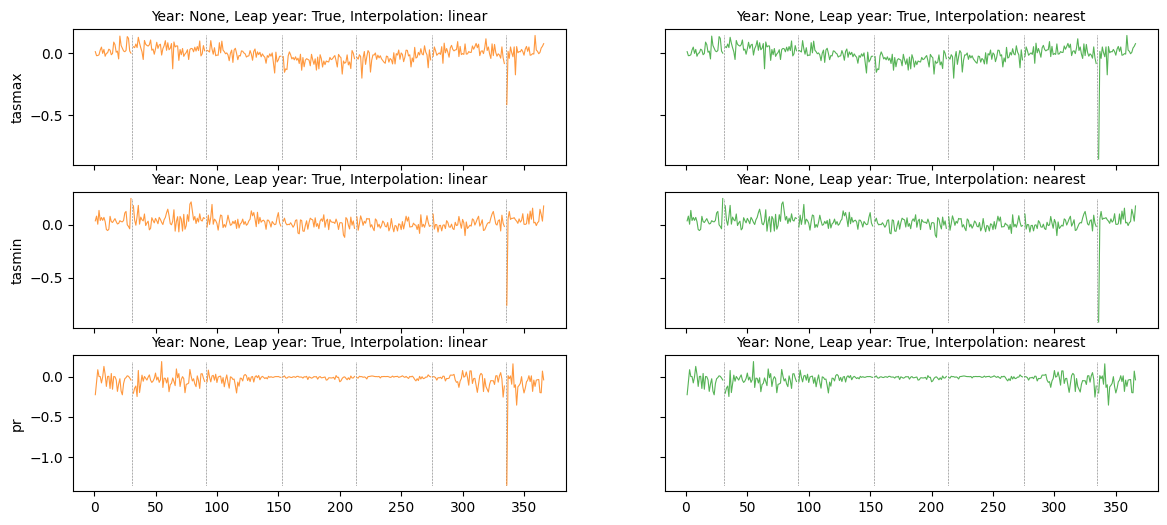

Plot diff: False; year: None; leap_year: False


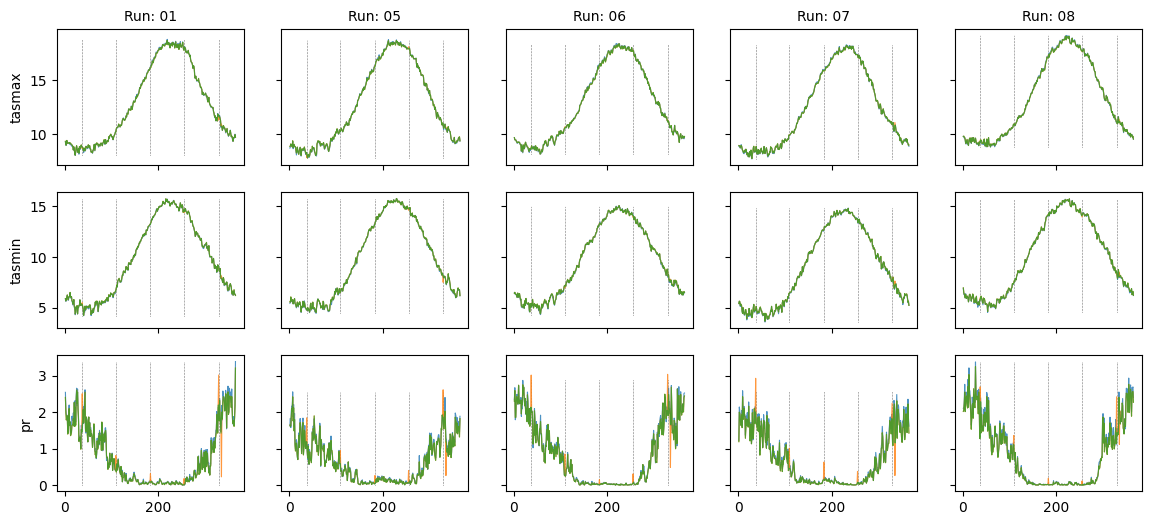

Plot diff: True; year: None; leap_year: False


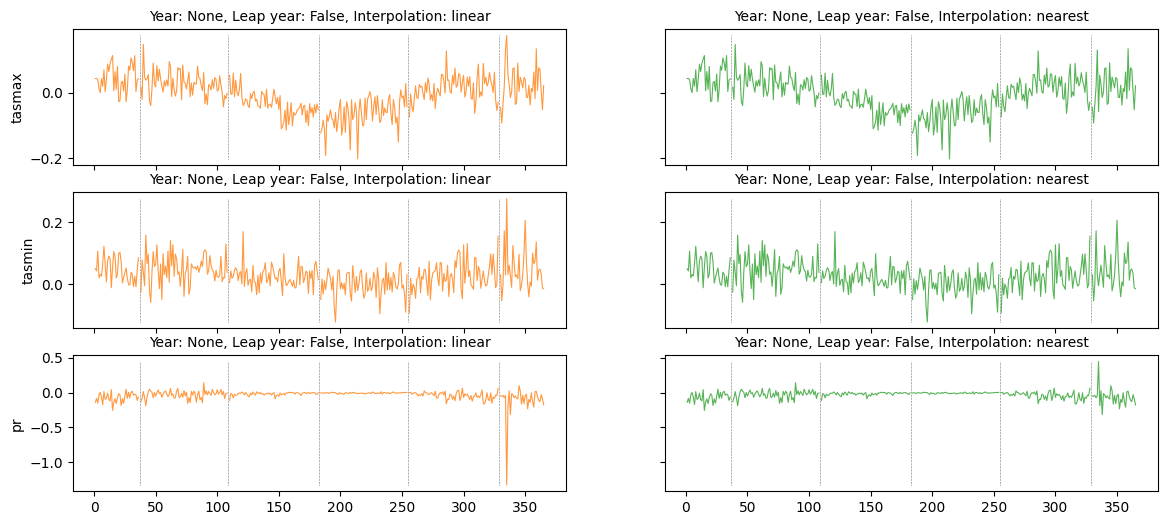

Plot diff: False; year: 1984; leap_year: True


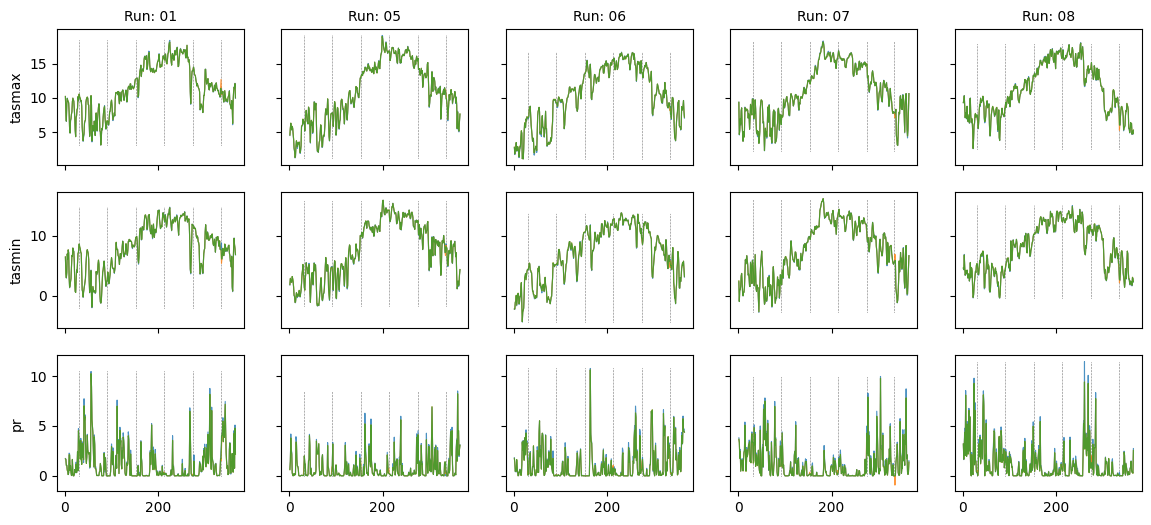

Plot diff: True; year: 1984; leap_year: True


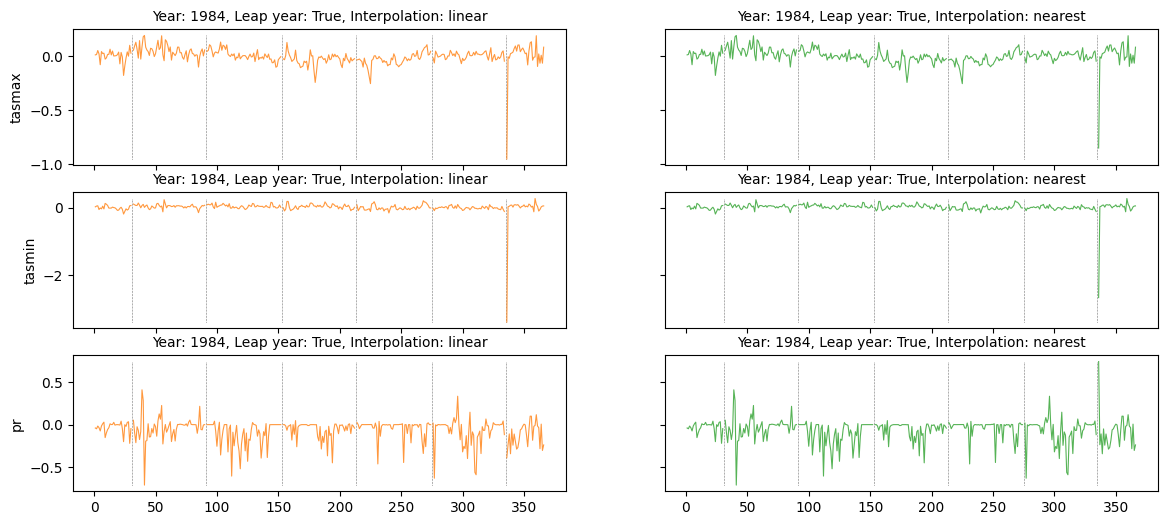

Plot diff: False; year: 1983; leap_year: False


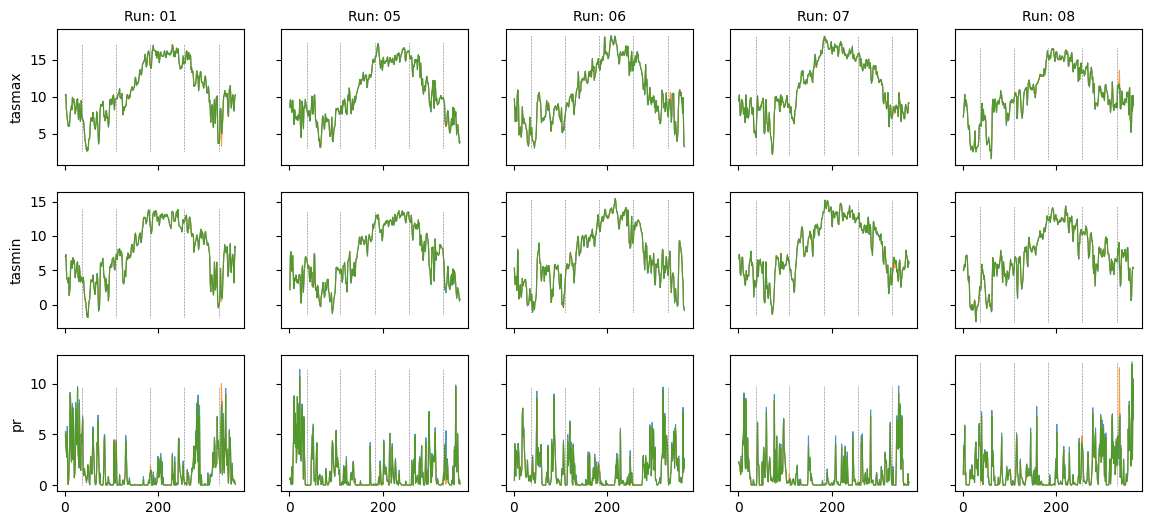

Plot diff: True; year: 1983; leap_year: False


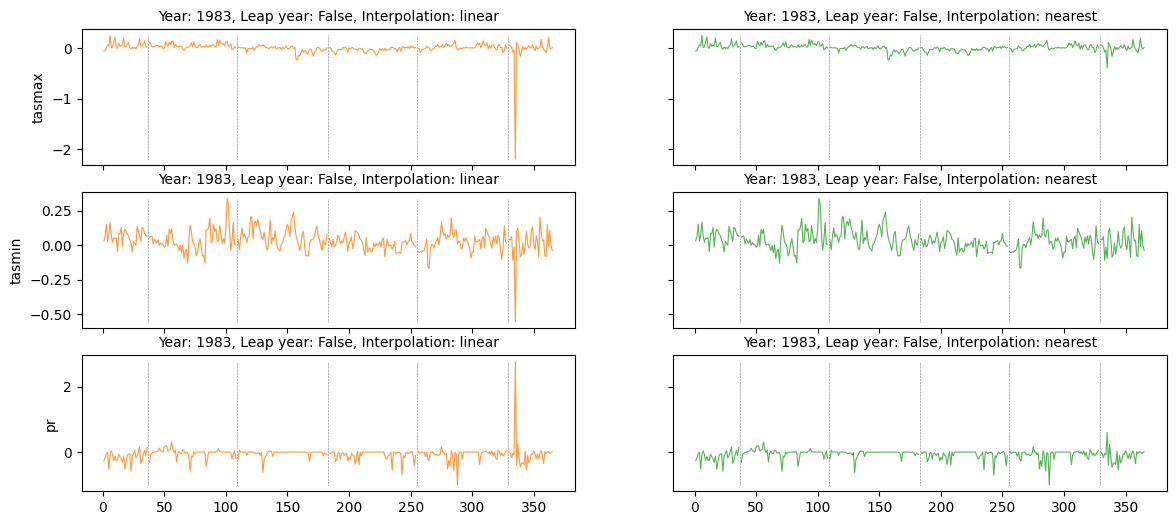

In [12]:
# Plot arrays
for year in [None, 1984]:
    for leap_year in [True, False]:
        for plot_diff in [False, True]:
            if year is not None:
                actual_year = year if leap_year else 1983
            else:
                actual_year = None
            print(
                f"Plot diff: {plot_diff}; year: {actual_year}; leap_year: {leap_year}"
            )
            if not plot_diff:
                plot_array(
                    data, year=actual_year, leap_year=leap_year, plot_diff=plot_diff
                )
            else:
                # run_var="01" as an example
                plot_array_pair_diff(
                    data, run_var="01", year=actual_year, leap_year=leap_year
                )
            plt.show()

In [13]:
def explore_year_range_xlim(
    year_range, leap_years: bool, var="tasmax", run_var="01", xlim=(320, 340)
):
    for year in year_range:
        if year % 4 == (1 if leap_years else 0):
            continue
        print(f"raw (blue), linear (orange), nearest (green) values; year: {year}")
        # Explore location of spike in difference in var="tasmax", run_var="08"
        plot_by_day(
            data,
            var,
            run_var,
            year=year,
            leap_year=False,
            plot_diff=False,
            ax=plt.gca(),
        )
        # Subset days to region where spike is
        plt.xlim(*xlim)
        plt.show()
        print(f"linear - raw (orange), nearest - raw (green); year: {year}")
        plot_by_day(
            data,
            var,
            run_var,
            year=year,
            leap_year=False,
            plot_diff=True,
            ax=plt.gca(),
        )
        plt.xlim(*xlim)
        plt.show()

raw (blue), linear (orange), nearest (green) values; year: 1981


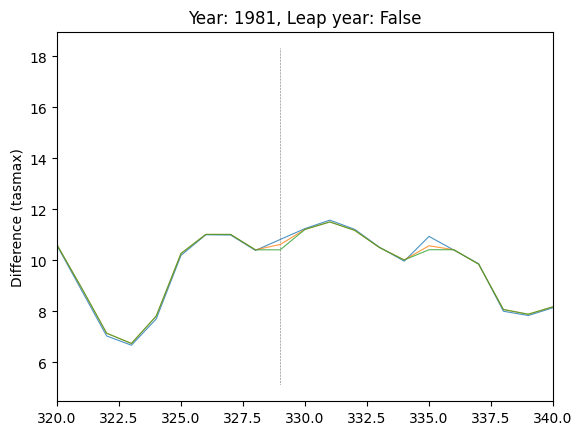

linear - raw (orange), nearest - raw (green); year: 1981


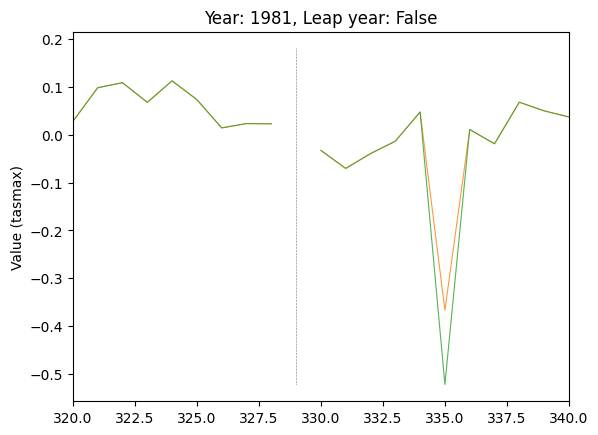

raw (blue), linear (orange), nearest (green) values; year: 1982


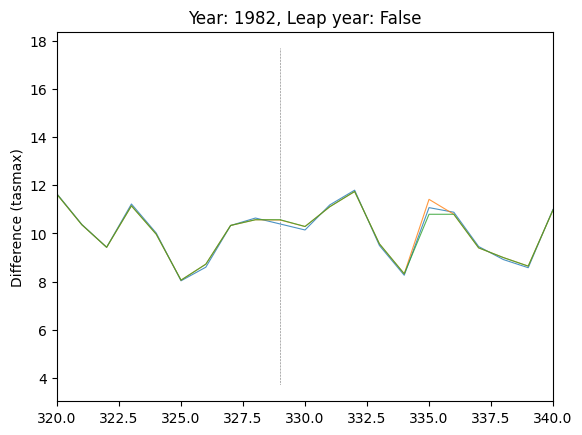

linear - raw (orange), nearest - raw (green); year: 1982


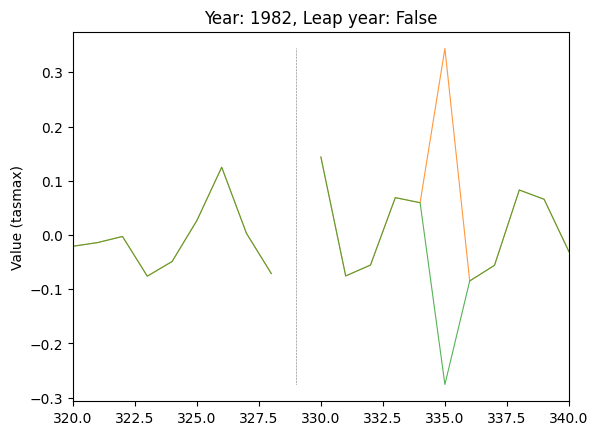

raw (blue), linear (orange), nearest (green) values; year: 1983


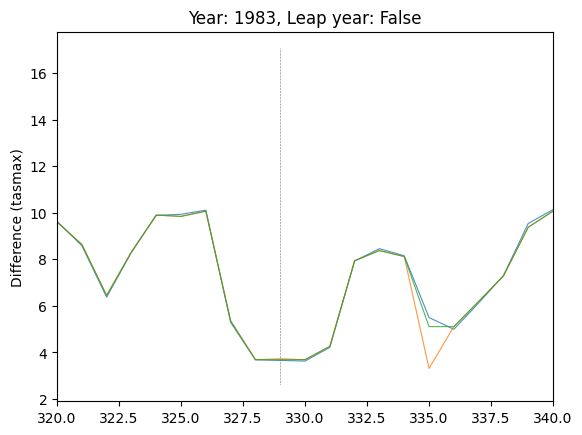

linear - raw (orange), nearest - raw (green); year: 1983


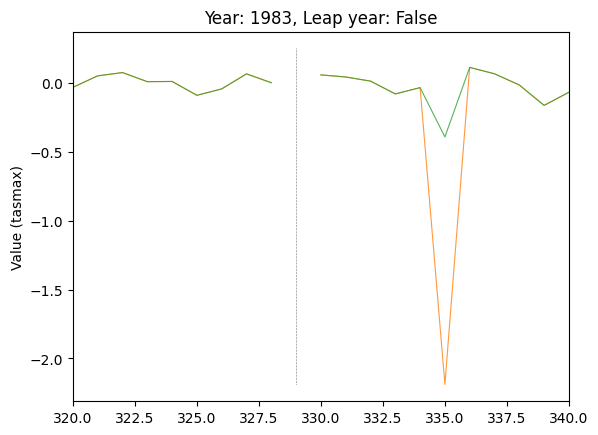

raw (blue), linear (orange), nearest (green) values; year: 1985


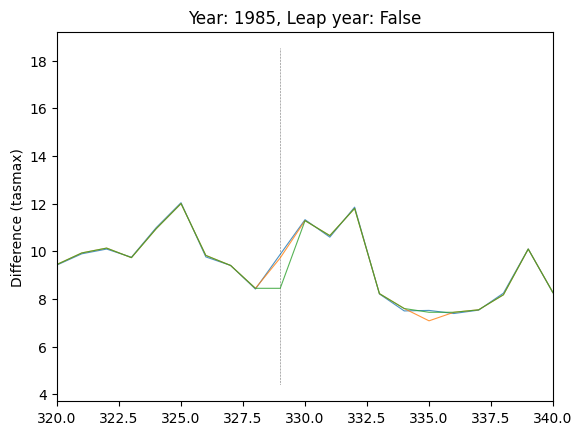

linear - raw (orange), nearest - raw (green); year: 1985


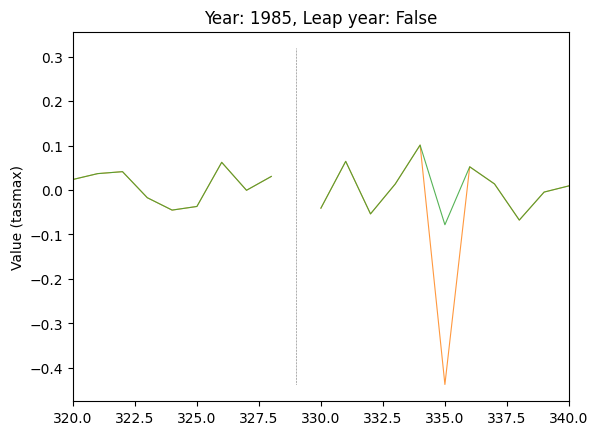

raw (blue), linear (orange), nearest (green) values; year: 1986


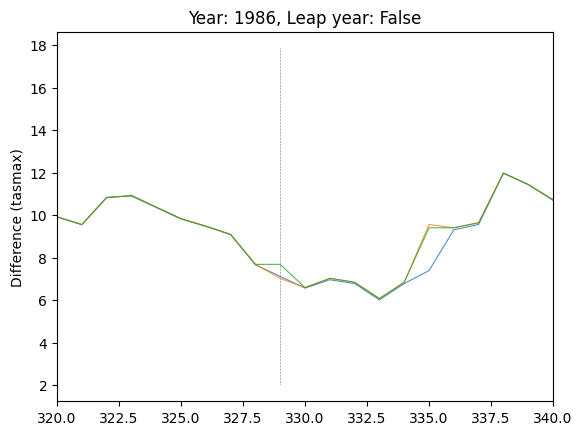

linear - raw (orange), nearest - raw (green); year: 1986


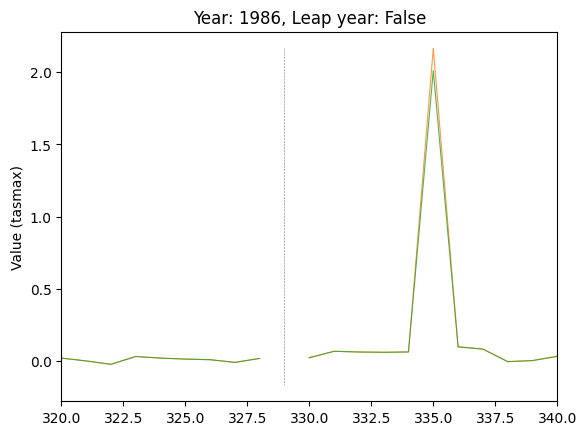

raw (blue), linear (orange), nearest (green) values; year: 1987


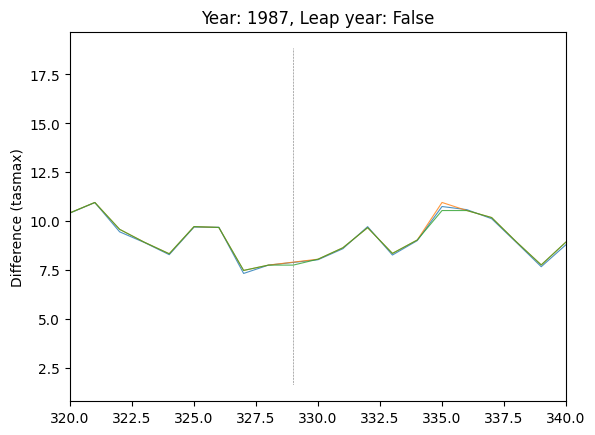

linear - raw (orange), nearest - raw (green); year: 1987


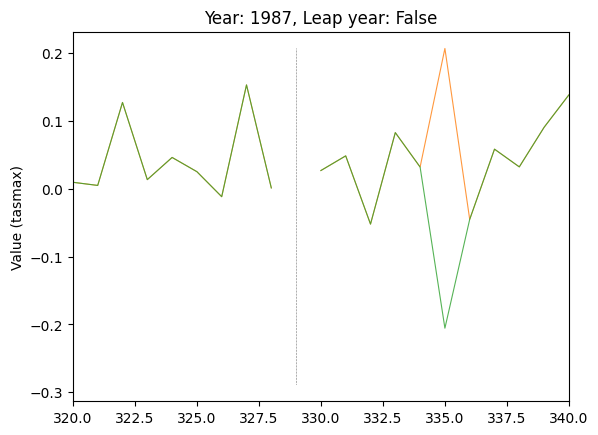

In [14]:
explore_year_range_xlim(list(range(1981, 1989)), leap_years=False)

raw (blue), linear (orange), nearest (green) values; year: 1981


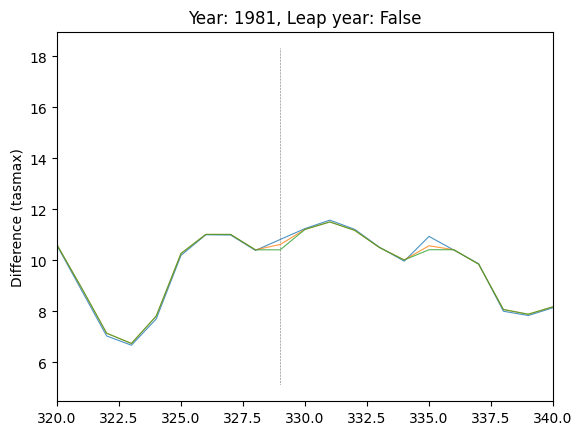

linear - raw (orange), nearest - raw (green); year: 1981


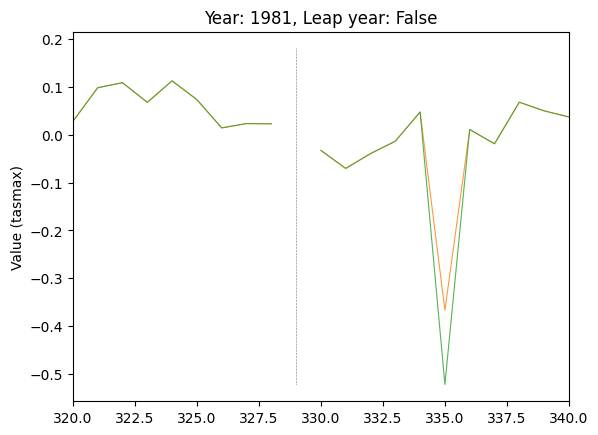

raw (blue), linear (orange), nearest (green) values; year: 1982


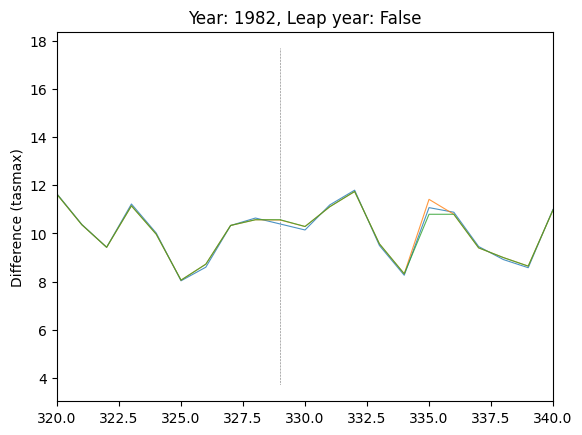

linear - raw (orange), nearest - raw (green); year: 1982


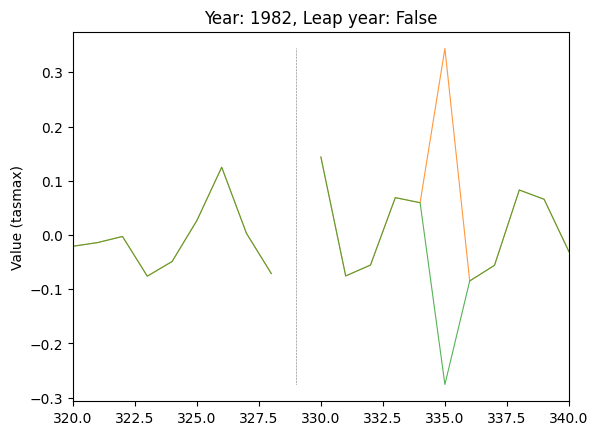

raw (blue), linear (orange), nearest (green) values; year: 1983


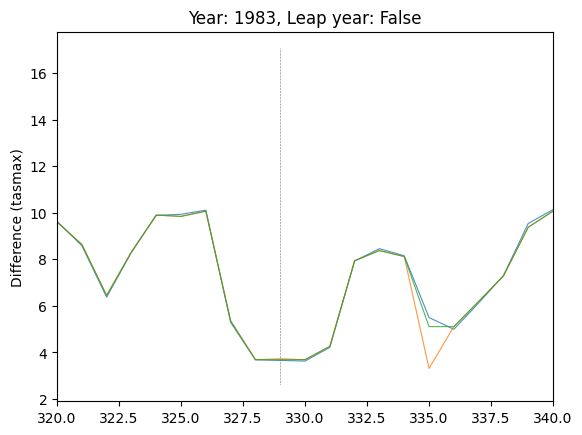

linear - raw (orange), nearest - raw (green); year: 1983


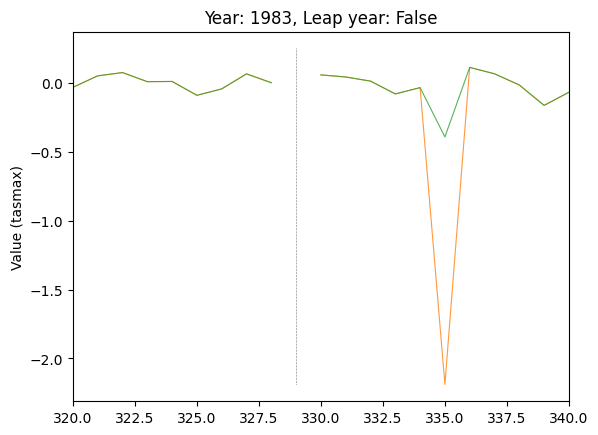

raw (blue), linear (orange), nearest (green) values; year: 1985


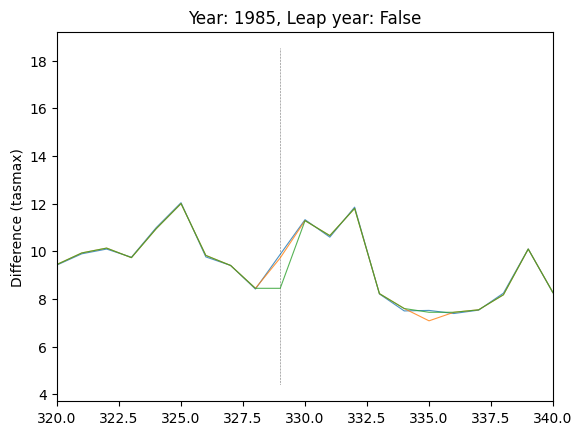

linear - raw (orange), nearest - raw (green); year: 1985


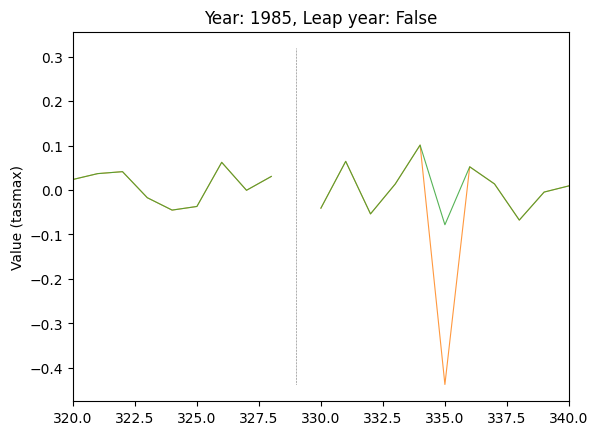

raw (blue), linear (orange), nearest (green) values; year: 1986


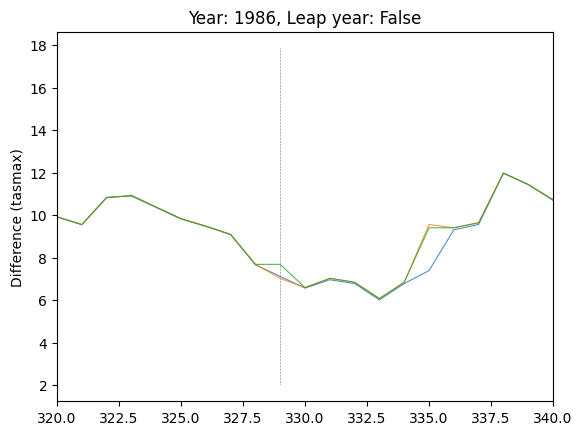

linear - raw (orange), nearest - raw (green); year: 1986


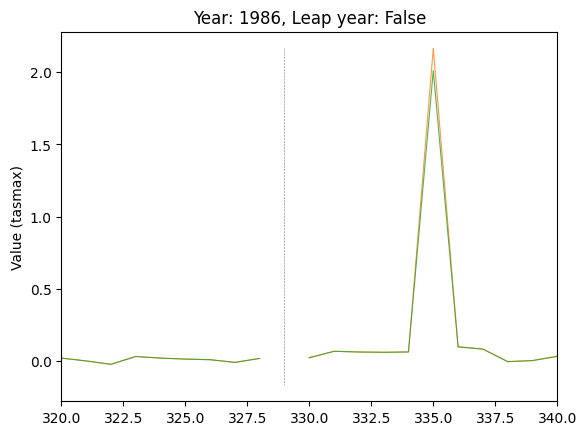

raw (blue), linear (orange), nearest (green) values; year: 1987


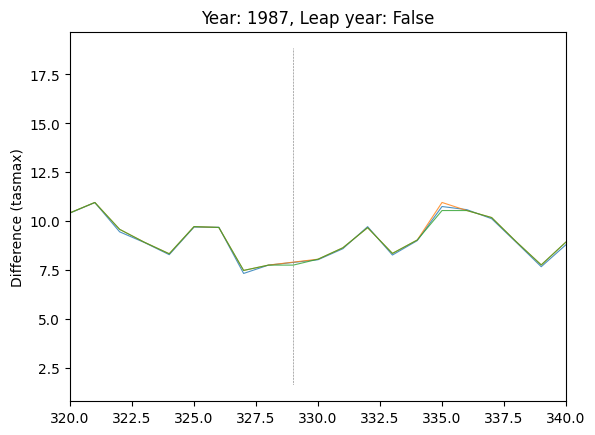

linear - raw (orange), nearest - raw (green); year: 1987


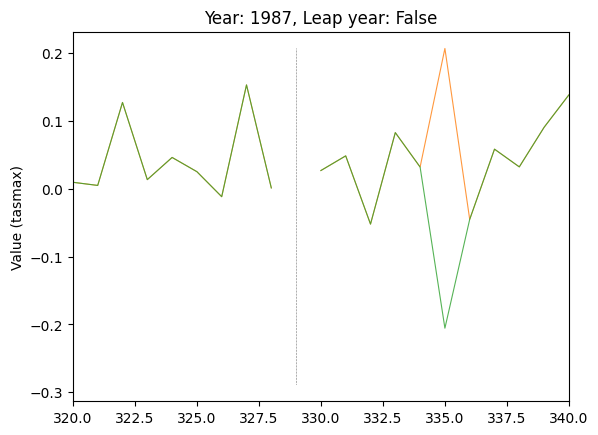

In [15]:
explore_year_range_xlim(list(range(1981, 1989)), leap_years=False)